In [26]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt

In [27]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import f1_score, classification_report

In [28]:
path_to_data = r'/home/kyudin/data/jmcl/'

# EDA по данным
    1) Определение минимального количества просмотров на video_id для получения достоверной оценки доли мужчин/женщин:
    
    Есть DAG, в котором ежедневно собираются логи просмотров авторизованных пользователей с указанными социально-демографическими данными (пол и/или возраст) с последующей записью статистики в ClickHouse. 
    В качестве признаков video_id будем собирать статистику просмотров мужчин/женщин на видео. Однако такой признак может получиться довольно шумным, если не задать порог минимального количества просмотров на видео (например, если видео посмотрели 5 мужчин и 0 женщин – то у него 100% мужского сегмента, что может быть далеко не правда)
    
    Необходимо определить такое минимальное количество просмотров на видео, при котором соотношение мужчин и женщин будет сходиться к истинному с максимальной ошибкой в  10%  (под истинным будем считать статистику видео с количеством просмотров более 100)

### 1. Определение минимального количества просмотров на video_id для получения достоверной оценки доли мужчин/женщин

    - Посмотрим на распределение n (количество просмотров на видео) для наборов video_id где:
            1) оценка сошлась
            2) не сошлась с финальной долей.
            
    - Отберем порог: построим precision-recall кривую по порогам n
    - Будем считать, что recall для нас важнее: хотим определить как можно больше видео с доверительной оценкой доли мужчин
    - Полученное значение будем использовать в фильтрации при выгрузке признаков video_id

In [29]:
video_id_sex_feats = pd.read_csv(path_to_data + 'video_id_sex_feats.csv')

In [30]:
video_id_sex_feats.head()

,report_date,video_id,cumulative_male,cumulative_female,video_users_total
0,2025-02-03,00000886adb138c991f36b38d5ef776f,6,0,6
1,2025-03-14,00002b74994f00cafcbf2fb796551561,51,153,204
2,2025-03-15,00002b74994f00cafcbf2fb796551561,69,222,291
3,2025-03-16,00002b74994f00cafcbf2fb796551561,78,228,306
4,2025-03-17,00002b74994f00cafcbf2fb796551561,99,258,357


In [31]:
video_id_w_100_views = video_id_sex_feats[video_id_sex_feats['video_users_total'] >= 100]
video_id_wo_100_views = video_id_sex_feats[video_id_sex_feats['video_users_total'] < 100]

In [32]:
video_id_true_men_ratio = video_id_w_100_views.loc[
    video_id_w_100_views.groupby('video_id')['video_users_total'].idxmax()
].copy()

In [33]:
video_id_true_men_ratio['p'] = video_id_true_men_ratio['cumulative_male'] / video_id_true_men_ratio['video_users_total']
video_id_true_men_ratio.sample(5)

,report_date,video_id,cumulative_male,cumulative_female,video_users_total,p
16198090,2025-01-08,8057ca9bba6b39c917b1332de4bd7039,104,20,124,0.838710
11143585,2025-06-07,581c45e95f5435c5c8a669e7b5678b80,536,318,854,0.627635
12554013,2025-06-14,6353975481c48b8e10d16a879d10252e,4204,5124,9328,0.450686
25510273,2025-03-28,ca2af5e066d99ee2e58c678be01c121f,820,298,1118,0.733453
25347086,2025-04-22,c8e264762fa8d6fe0f3f91cc27707828,110,27,137,0.802920


In [34]:
video_id_wo_100_views['p_estim'] = video_id_wo_100_views['cumulative_male'] / video_id_wo_100_views['video_users_total']

video_id_wo_100_views = (
    video_id_wo_100_views
    .merge(
        video_id_true_men_ratio[['video_id', 'p']],
        on='video_id',
        how='inner'
    )
)

video_id_wo_100_views.head()

/tmp/ipykernel_1666989/2972252143.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_id_wo_100_views['p_estim'] = video_id_wo_100_views['cumulative_male'] / video_id_wo_100_views['video_users_total']


,report_date,video_id,cumulative_male,cumulative_female,video_users_total,p_estim,p
0,2024-09-22,00004cc918ea9832e88a94a68445d9a7,8,0,8,1.000000,0.925926
1,2024-09-23,00004cc918ea9832e88a94a68445d9a7,16,4,20,0.800000,0.925926
2,2024-09-24,00004cc918ea9832e88a94a68445d9a7,28,4,32,0.875000,0.925926
3,2024-09-25,00004cc918ea9832e88a94a68445d9a7,36,4,40,0.900000,0.925926
4,2024-09-26,00004cc918ea9832e88a94a68445d9a7,52,4,56,0.928571,0.925926


In [35]:
video_id_wo_100_views['acc_err'] = (video_id_wo_100_views['p_estim'] - video_id_wo_100_views['p']).abs() < 0.10
video_id_wo_100_views.head()

,report_date,video_id,cumulative_male,cumulative_female,video_users_total,p_estim,p,acc_err
0,2024-09-22,00004cc918ea9832e88a94a68445d9a7,8,0,8,1.000000,0.925926,True
1,2024-09-23,00004cc918ea9832e88a94a68445d9a7,16,4,20,0.800000,0.925926,False
2,2024-09-24,00004cc918ea9832e88a94a68445d9a7,28,4,32,0.875000,0.925926,True
3,2024-09-25,00004cc918ea9832e88a94a68445d9a7,36,4,40,0.900000,0.925926,True
4,2024-09-26,00004cc918ea9832e88a94a68445d9a7,52,4,56,0.928571,0.925926,True


In [36]:
video_id_wo_100_views_true = video_id_wo_100_views[video_id_wo_100_views['acc_err'] == True]

video_id_converg_stats = video_id_wo_100_views_true.loc[
    video_id_wo_100_views_true.groupby('video_id')['video_users_total'].idxmin()
]

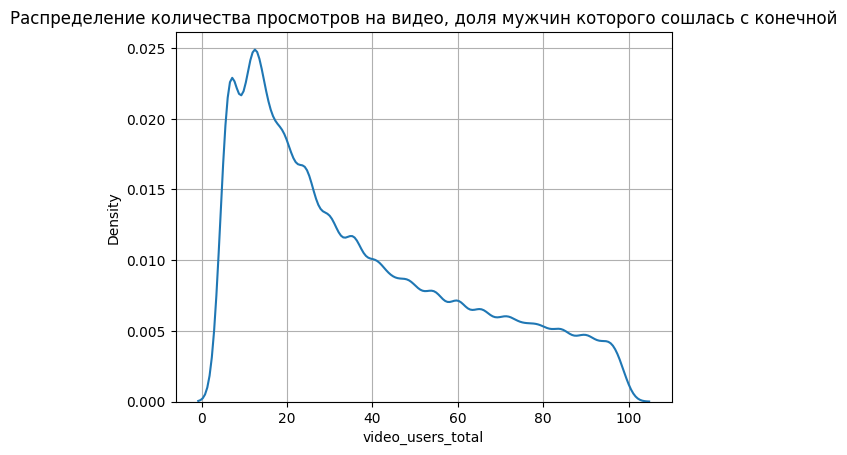

In [50]:
sns.kdeplot(
    video_id_converg_stats['video_users_total']
).set_title('Распределение количества просмотров на видео, доля мужчин которого сошлась с конечной')
plt.grid()

In [51]:
video_id_converg_stats['video_users_total'].describe()

count    415393.000000
mean         36.523706
std          25.764305
min           5.000000
25%          15.000000
50%          30.000000
75%          54.000000
max          99.000000
Name: video_users_total, dtype: float64

In [39]:
video_id_wo_100_views_false = video_id_wo_100_views[video_id_wo_100_views['acc_err'] == False]

video_id_not_converg_stats = video_id_wo_100_views_false.loc[
    video_id_wo_100_views_false.groupby('video_id')['video_users_total'].idxmax()
]

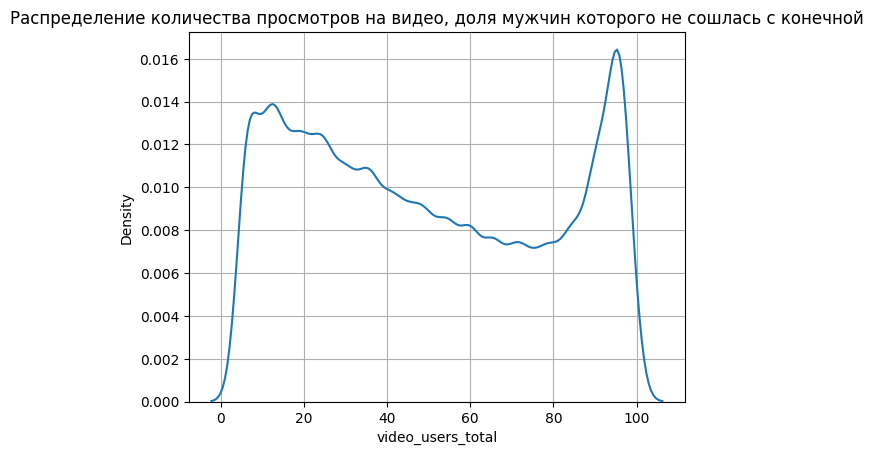

In [53]:
sns.kdeplot(video_id_not_converg_stats['video_users_total'])\
    .set_title('Распределение количества просмотров на видео, доля мужчин которого не сошлась с конечной')
plt.grid()

In [41]:
video_id_not_converg_stats['video_users_total'].describe()

count    293575.000000
mean         49.525910
std          29.784577
min           5.000000
25%          24.000000
50%          46.000000
75%          78.000000
max          99.000000
Name: video_users_total, dtype: float64

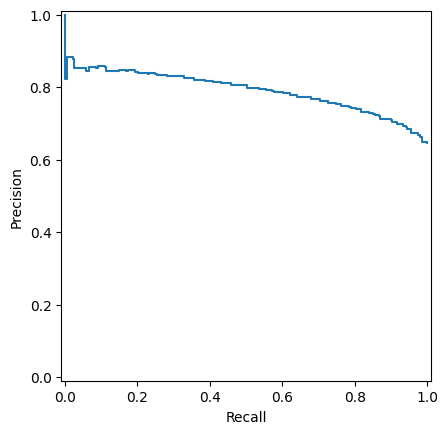

In [54]:
y = video_id_wo_100_views['acc_err'].astype(int).values # 1 – сходится, 0 – не сходится
video_users_score = video_id_wo_100_views['video_users_total'].values

prec, recall, thresholds = precision_recall_curve(y, video_users_score)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [57]:
mask = recall <= 0.81
first_index = np.argmax(mask)

recall[first_index], thresholds[first_index]

(0.8038812825248179, 33)

In [56]:
y_pred = np.array([0] * len(video_users_score))
pos_mask = np.where(video_users_score >= thresholds[first_index])
y_pred[pos_mask] = 1
f1_score(y, y_pred)

0.771613725959033

In [58]:
print(
    classification_report(y, y_pred)
)

              precision    recall  f1-score   support

           0       0.58      0.49      0.53   1293761
           1       0.74      0.80      0.77   2348399

    accuracy                           0.69   3642160
   macro avg       0.66      0.65      0.65   3642160
weighted avg       0.68      0.69      0.69   3642160



## Выводы
    - 33 – минимальное количество просмотров на видео, при котором статистику будем считать доверительной
    - Порог немного смещенный, например, заметно большое количество video_id которые сошлись при n < 10 (по сути шум), возьмем 40